<a href="https://colab.research.google.com/github/MuQlanyu/python_lab/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22lab_work_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа

Баллы за секции:
- *Задание 1* - 10 баллов
- *Задание 2* - 20 баллов
- *Задание 3* - 30 баллов
- **Итого** - 60 баллов

Оценка за лабу $ = \frac{score}{6}$

## Внимание! Attention! Achtung!

**Данная лабораторная работа является блокирующей**, т.е. если лабораторная работа не выполнена, то оценка за курс - неуд.

Лабораторная работа считается выполненной, если **за каждое из заданий получено не менее 2 баллов**.

## Формат сдачи лабораторной работы

Данная лабораторная работа сдается так же, как и проект - заполняете данный ноутбук, отправляете его через GitHub с указанием проверяющего.

**Ассистенты не будут запускать ячейки кода, а смотреть на выведенный результат и код. Если ячейка кода не запущена - балл не ставится, даже при правильно написанном коде.**

***(Комментарии что курс по Python легче чем по C++ учтены)***

>**Примечание**
>
>Данные задания вдохновлены предметом "Введение в анализ данных" 2 курса, по итогу которого идёт отбор на DS-поток. Если вы видите себя в смежных областях, советуем выполнить данную лабораторку по максимуму.

In [244]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, иначе вас забанят. Просрочка дедлайна по этой причине не принимается!</b>

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [245]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Репетитор",
    'area': 1,
    'page': 0,
    'per_page': 100
}

data = requests.get(URL, params).json()
data.keys()
# Чтобы не засорять глобальный скоуп
del data, params

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [246]:
amount_of_vacancies_per_page = 100

def param(page, name):
  return {'text': name, 'area': 1, 'page': page, 'per_page': amount_of_vacancies_per_page}


#Задаем базовые профессии и словарь датафреймов
jobs = ['Дизайнер одежды', 'Ночной администратор', 'Программист C++', 'Юрист по недвижимости', 'Повар в ресторан']
df = dict()


for job in jobs:
  pages = requests.get(URL, param(1, job)).json()['pages']
  #df[job] = pd.concat([pd.DataFrame(requests.get(URL, param(page + 1, job)).json()['items']) for page in range(pages)])
  # Можно было в одну строку, но могут забанить, поэтому приходится писать так
  df[job] = pd.DataFrame(requests.get(URL, param(0, job)).json()['items'])
  for page in range(1, pages):
    df[job] = pd.concat([pd.DataFrame(requests.get(URL, param(page, job)).json()['items']), df[job]], ignore_index=True)
    sleep(0.1)

(1 балл) Посчитайте сколько всего найдено вакансий:

In [247]:
sum([df[job].shape[0] for job in jobs])

3929

(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [248]:
class Company:

  name = None
  lat = None
  lng = None

  def __init__(self, name, lat = None, lng = None):
    self.name = name
    self.lat = lat
    self.lng = lng

(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [249]:
companies = dict()
for job in jobs:
  for index, row in (df[job][['employer', 'address']]).iterrows():
    if row['employer']['name'] is not None and row['employer']['name'] not in companies:
      if row['address'] is None:
        companies[row['employer']['name']] = Company(row['employer']['name'])
      else:
        companies[row['employer']['name']] = Company(row['employer']['name'], row['address']['lat'], row['address']['lng'])


(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [250]:
cnt = 0
for job in jobs:
  for index, row in df[job].iterrows():
    if row['address'] != None: cnt += 1
cnt

2914

(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [251]:
# Раз можно грубо, то булем считать, что МКАД - это круг
center = (55.759443, 37.617818) # Взял "на глаз" центр
MKAD_point= (55.573987, 37.634634) # точка мкада
radius_square = ((center[0] - MKAD_point[0]) ** 2 + (center[1] - MKAD_point[1]) ** 2)

def is_in_mkad(address):
  if address['lat'] is None or address['lng'] is None: return False
  return (address['lat'] - center[0]) ** 2 + (address['lng'] - center[1]) ** 2 <= radius_square

lat = list()
lng = list()
vacs_in_mkad = list()
for job in jobs:
  for index, row in df[job].iterrows():
    if row['address'] == None: continue
    if is_in_mkad(row['address']):
      lat.append(row['address']['lat'])
      lng.append(row['address']['lng'])
      vacs_in_mkad.append(row)

(1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

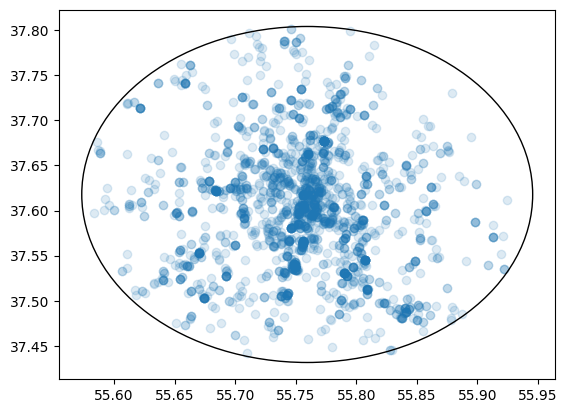

In [252]:
figure, ax = plt.subplots(1)
ax.scatter(lat, lng, alpha = 0.15)
ax.add_patch(plt.Circle(center, radius_square**(1/2), fill=False)) # Примерно мкад
plt.show()

In [253]:
# очищаем глобальный скоуп
del URL, amount_of_vacancies_per_page, jobs, df, companies, cnt, center, MKAD_point, radius_square, lat, lng, vacs_in_mkad, figure, ax

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве): 

In [254]:
# your code here

(2 балла) **Сделайте выводы о проделанной работе:**

>*Подсказки для маленьких: Что вы можете сказать про районы Москвы? Что вы можете сказать про зарплаты? Что вы можете сказать про спрос?*

Ваши выводы здесь :)

## Задание 2. Анализ данных - 20 баллов

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [255]:
!gdown 1uIWeZFz3ElB5p1brBVEwJBHTbjXNPdfU

Downloading...
From: https://drive.google.com/uc?id=1uIWeZFz3ElB5p1brBVEwJBHTbjXNPdfU
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 226MB/s]


Создадим DataFrame:

In [256]:
diamonds = pd.read_csv("diamonds.csv")
diamonds

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,None,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,None,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,None,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,...,8.66,M,STK,unknown,None,unknown,unknown,unknown,unknown,1210692
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,...,5.71,TK,XTK,unknown,None,Green,unknown,None,Fancy Light,1292500
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,...,10.20,TN,M,unknown,None,unknown,unknown,unknown,unknown,1315496
219701,219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,...,3.47,XTN,VTK,unknown,Faint,Red,unknown,unknown,Fancy,1350000


(0.5 балла) Выведете первые 5 строк датасета:

In [257]:
diamonds.head(5)

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,None,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,None,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,None,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [258]:
diamonds.shape[0]

219703

(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [259]:
pd.concat([diamonds[['total_sales_price']][diamonds['total_sales_price'] == diamonds['total_sales_price'].max()],
           diamonds[['total_sales_price']][diamonds['total_sales_price'] == diamonds['total_sales_price'].min()]])

,total_sales_price
219702,1449881
0,200
1,200
2,200
3,200
4,200
5,200
6,200
7,200
8,200


(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [260]:
diamonds.isin(['None', "unknown"]).sum().sum()

1891168

(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [261]:
print(*list(diamonds.T[diamonds.isin(['None', "unknown"]).sum() > 0].T.columns))

color cut_quality eye_clean culet_size culet_condition girdle_min girdle_max fluor_color fluor_intensity fancy_color_dominant_color fancy_color_secondary_color fancy_color_overtone fancy_color_intensity


В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными. 

Ваша задача:

1. (0.5 балла) найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [262]:
list_of_garbage = [i for i in list(diamonds.columns) if i.startswith('fancy_color_') or i.startswith('fluor_')]
len(list_of_garbage)

6

2. (0.5 балла) найти количество информативных (не `None` или `unknown`) значений в этих колонках: 

In [264]:
diamonds.shape[0] * len(list_of_garbage) - diamonds.isin(['None', "unknown"]).sum()[list_of_garbage].sum()

111586

3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [265]:
diamonds.drop(axis=1, inplace=True, labels=list_of_garbage)

(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [266]:
diamonds.drop(axis=1, inplace=True, labels=[i for i in list(diamonds.columns) if i.startswith('culet_')])

(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [267]:
diamonds['total_sales_price'].sum()/ 1000

1517721.991

Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [268]:
diamonds[::2]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219694,219695,Round,D,IF,12.52,Excellent,HRD,Excellent,Excellent,unknown,62.1,58.0,14.84,14.91,9.24,unknown,unknown,1121792
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496


(0.5 балла) А теперь с индексами, кратными 6:

In [269]:
diamonds[::6]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.0,60.0,2.91,2.92,1.78,M,M,200
24,24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,unknown,0.0,0.0,0.00,0.00,0.00,unknown,unknown,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219678,219679,Round,G,VS1,10.23,Excellent,GIA,Excellent,Excellent,unknown,62.7,55.0,13.82,13.92,8.69,TN,M,859320
219684,219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,63.8,57.0,6.44,4.96,3.16,TK,VTK,982560
219690,219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,unknown,59.4,59.0,14.07,14.15,8.39,M,STK,1040739
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347


(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [271]:
diamonds_cat = diamonds[['cut', 'color', 'clarity', 'cut_quality', 'lab', 'symmetry', 'polish', 'girdle_min', 'girdle_max']]
diamonds_cat

,cut,color,clarity,cut_quality,lab,symmetry,polish,girdle_min,girdle_max
0,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,M,M
1,Round,E,VVS2,Very Good,IGI,Very Good,Very Good,STK,STK
2,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,TN,M
3,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,M,STK
4,Round,E,VVS2,Very Good,IGI,Very Good,Excellent,STK,STK
...,...,...,...,...,...,...,...,...,...
219698,Round,E,VS1,Excellent,GIA,Excellent,Excellent,M,STK
219699,Radiant,unknown,VS2,unknown,GIA,Very Good,Very Good,TK,XTK
219700,Round,E,VS1,Excellent,GIA,Excellent,Excellent,TN,M
219701,Princess,unknown,SI2,unknown,GIA,Good,Good,XTN,VTK


>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

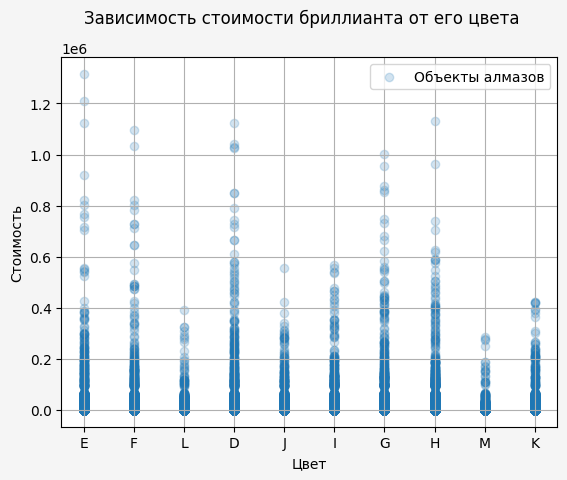

In [272]:
fig = plt.figure(facecolor='whitesmoke', dpi=100)
clear_df = diamonds[diamonds['color'] != 'unknown']

plt.scatter(
    clear_df['color'].tolist(),
    clear_df['total_sales_price'].tolist(),
    alpha=0.2,
    label="Объекты алмазов"
    )

plt.suptitle("Зависимость стоимости бриллианта от его цвета")

plt.xlabel("Цвет")
plt.ylabel("Стоимость")

plt.legend(loc='upper right')

plt.grid(True)
plt.show()

(2 балла) Постройте график `лабараторная оценка - кол-во бриллиантов`:

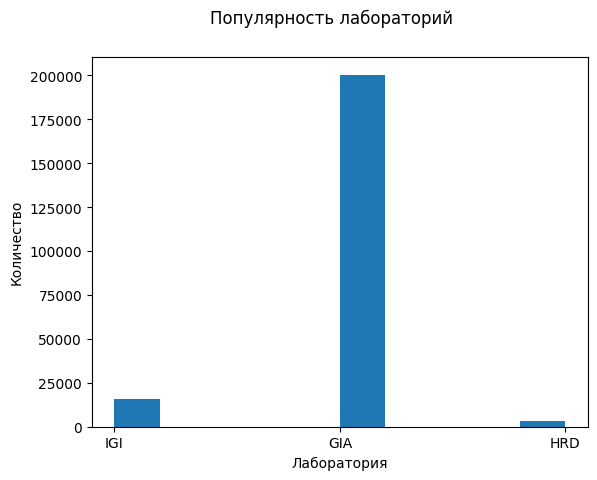

In [273]:
plt.hist(diamonds['lab'])

plt.suptitle("Популярность лабораторий")

plt.xlabel("Лаборатория")
plt.ylabel("Количество")
plt.show()

(2 балла) Постройте график `вес бриллианта - стоимость`:

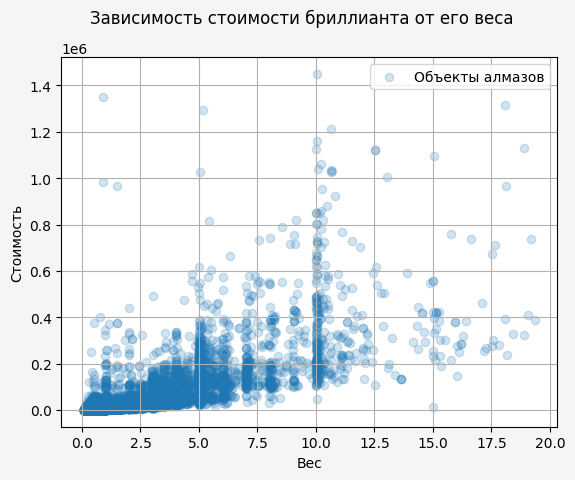

In [274]:
fig = plt.figure(facecolor='whitesmoke', dpi=100)

plt.scatter(
    diamonds['carat_weight'].tolist(),
    diamonds['total_sales_price'].tolist(),
    alpha=0.2,
    label="Объекты алмазов"
    )

plt.suptitle("Зависимость стоимости бриллианта от его веса")

plt.xlabel("Вес")
plt.ylabel("Стоимость")

plt.legend(loc='upper right')

plt.grid(True)
plt.show()

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

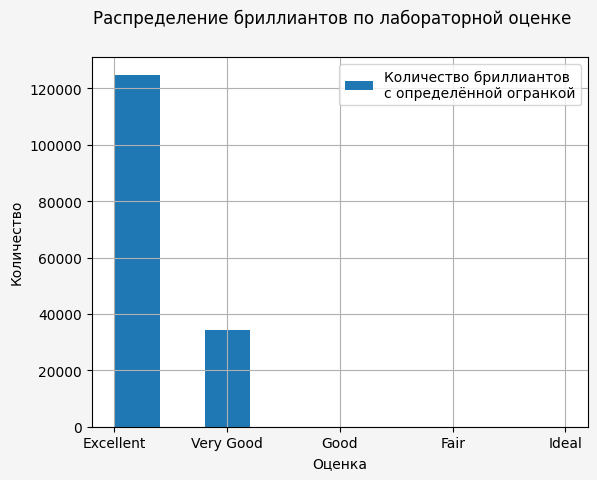

In [275]:
fig = plt.figure(facecolor='whitesmoke', dpi=100)
clear_df = diamonds[diamonds['cut_quality'] != 'unknown']

plt.hist(clear_df['cut_quality'], label="Количество бриллиантов\nс определённой огранкой")

plt.suptitle("Распределение бриллиантов по лабораторной оценке")

plt.xlabel("Оценка")
plt.ylabel("Количество")

plt.legend(loc='upper right')

plt.grid(True)
plt.show()

(2 балла) **Сделайте выводы по построенным графикам:**

>*Подсказка для маленьких: Что вы можете сказать о графиках полученных выше для данного датасета?*

1) Обычно стоимость бриллианта не зависит от его цвета

2) Самая популярная лаборатория из рассмотренных это GIA, далее идет IGI и на последнем месте HRD

3) Минимальная цена бриллианта и цена зависит от его веса, при этом большинство имеют вес не больше 10 карат

4) Большинство рассмотренных бриллиантов имеют качество Excellent, а остальные Very Good

In [276]:
# Очищаем глобальный скоуп
del list_of_garbage, fig, clear_df

## Задание 3. Модель - 30 баллов

В данном задании вам предстоит построить классифицирующую модель размер алмаза и его стоимости, а затем оценить полученную модель.

>**Примечание**
>
>Данная модель не претендует на самый верный индикатор стоимости алмаза, ведь мы не учитываем ничего больше чем стоимость алмаза. Исключительно для образовательных целей :)

Для построения модели нам понадобится 4 столбца, а именно: 
- `meas_length`
- `meas_width`
- `meas_depth`
- `total_sales_price`

От остальных столбцов можно избавиться.

(1 балл) Создайте новый датасет и выведите его первые 10 строк: 

In [277]:
df = diamonds[['meas_length', 'meas_width', 'meas_depth', 'total_sales_price']]
df.head(10)

,meas_length,meas_width,meas_depth,total_sales_price
0,2.85,2.87,1.79,200
1,2.84,2.89,1.78,200
2,2.88,2.90,1.77,200
3,2.86,2.88,1.78,200
4,2.79,2.83,1.82,200
5,2.95,2.99,1.81,200
6,2.85,2.88,1.84,200
7,2.86,2.89,1.78,200
8,2.89,2.92,1.85,200
9,2.83,2.87,1.80,200


(1 балл) Перемешайте строки в датафрейме случайным образом: 

In [278]:
df = df.sample(frac = 1, ignore_index=True)
df

,meas_length,meas_width,meas_depth,total_sales_price
0,5.78,5.82,3.65,4141
1,5.35,5.39,3.34,3744
2,4.72,4.50,3.09,3262
3,3.52,3.14,2.46,1768
4,6.01,4.79,3.30,1638
...,...,...,...,...
219698,4.30,4.33,2.67,636
219699,4.65,4.68,2.81,1362
219700,4.35,4.38,2.69,1000
219701,6.18,4.52,2.91,2142


(1 балл) Сформируем новую колонку - для каждого бриллианта найдем сумму Минковского (p=3) по 3 измерениям бриллианта:

In [279]:
df['mink'] = ((df['meas_length'] - df['meas_width']).abs()**3 +\
             (df['meas_width'] - df['meas_depth']).abs()**3 + \
             (df['meas_depth'] - df['meas_length']).abs()**3) ** (1/3)

(1 балл) Сформируем новый датасет из двух колонок - сумма Минковского и `total_sales_price`: 

In [280]:
mink_price = pd.DataFrame([df['total_sales_price'], df['mink']]).T

(1 балл) Разделите вашу выборку на две части в соотношении 8:2 - одна выборка будет для тренировка, а другая для тестов вашей модели:

In [281]:
split = int(mink_price.shape[0] * 0.8)
main_part = mink_price.iloc[:split,:]
test_part = mink_price.iloc[split:,:]

(2 балла) Постройте график зависимости стоимости от вашего нового параметра размера для тренинг-выборки:

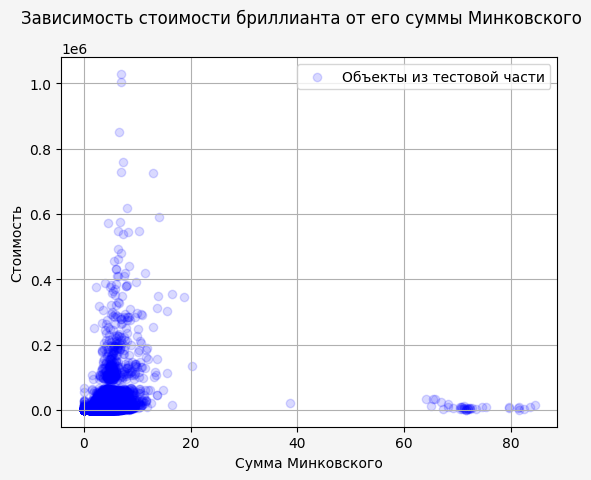

In [282]:
fig = plt.figure(facecolor='whitesmoke', dpi=100)

plt.scatter(
    test_part['mink'].tolist(),
    test_part['total_sales_price'].tolist(),
    alpha=0.15,
    label= "Объекты из тестовой части",
    color="blue"
    )

plt.suptitle("Зависимость стоимости бриллианта от его суммы Минковского")

plt.xlabel("Сумма Минковского")
plt.ylabel("Стоимость")

plt.legend(loc='upper right')

plt.grid(True)
plt.show()

(2 балла) Нанесите на тот же график тестовую выборку, используя другой цвет (не забудьте про параметр прозрачности):

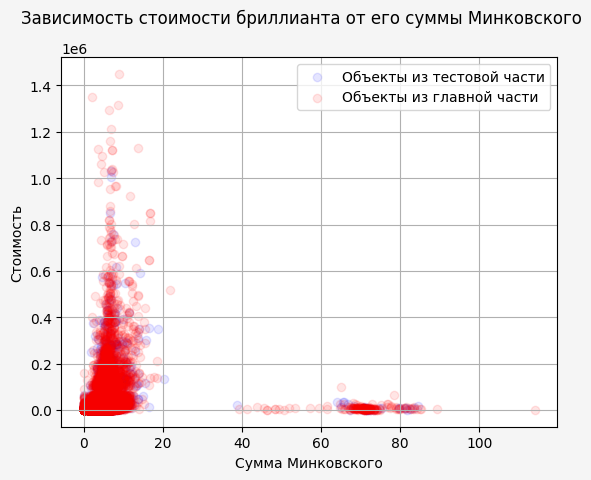

In [283]:
fig = plt.figure(facecolor='whitesmoke', dpi=100)

plt.scatter(
    test_part['mink'],
    test_part['total_sales_price'],
    alpha=0.1,
    label= "Объекты из тестовой части",
    color="blue"
    )

plt.scatter(
    main_part['mink'],
    main_part['total_sales_price'],
    alpha=0.1,
    label="Объекты из главной части",
    color="red"
    )

plt.suptitle("Зависимость стоимости бриллианта от его суммы Минковского")

plt.xlabel("Сумма Минковского")
plt.ylabel("Стоимость")

plt.legend(loc='upper right')

plt.grid(True)
plt.show()

(3 балла) Найдите для каждой бриллианта из тестовой выборки его "ближайшего соседа" из тренинг-выборки. Для каждого бриллианта из тестовой выборки найдите расстояния до соответствующего ближайшего соседа:

In [284]:
test_part['closest'] = test_part['mink']
for i in range(test_part.shape[0]):
  test_part.iloc[i]['closest'] = (test_part['mink'] - test_part.iloc[i]['closest']).abs().argsort()[1:].min()

<ipython-input-284-55e384a42e12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_part['closest'] = test_part['mink']
<ipython-input-284-55e384a42e12>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_part.iloc[i]['closest'] = (test_part['mink'] - test_part.iloc[i]['closest']).abs().argsort()[1:].min()


(3 балла) Найдите насколько сильно (в процентах) отличается цена бриллиантов из тестовой выборки от их соответствующих ближайших соседей:

In [ ]:
# your code here

**Данная модель является выдумкой автора. Не важен коэффициент ошибки, важны ваши шаги для получения коэффициента.**

### Введение в машинное обучение

Теперь давайте познакомимся с таким сильным инструментом как `sklearn`.

Вам необходимо:
1. выбрать 2 категориальных признака
2. на их основе обучить решающее дерево
3. оценить среднеквадратичную ошибку цены бриллианта
4. сделать пп. 1-3 и выбрать ту пару, которая дает лучший результат
5. сделать выводы

(3 балла) Мы работаем с категориальными признаками, для них не понятно что есть "больше" и "меньше". Поэтому нам нужно предварительно закодировать значения наших признаков, с чем нам поможет [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [285]:
import sklearn.preprocessing as prep

clear_df = diamonds[["cut", 'cut_quality']][diamonds['cut_quality'] != 'unknown']

model = clear_df[["cut", "cut_quality"]]

encoder = prep.OneHotEncoder()
translator = encoder.fit_transform(model)

for i in range(len(model.index)):
  model["cut"][i] = translator[i].indices[0]
  model["cut_quality"][i] = translator[i].indices[1]

(3 балла) Разбейте датасет на обучающую и тестовую выбору. Для этого вам поможет [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [286]:
import sklearn.model_selection as mod
main_part, test_part = mod.train_test_split(model)

(3 балла) Затем создайте и обучите вашу модель - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

(3 балла) Оцените ошибку вашей модели при помощи [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [ ]:
# your code here

(3 балла) **Сделайте выводы какие категориальные признаки лучше:**

*Подсказки для маленьких: Что вы можете сказать о зависимости по вашей выборке признаков? Какой вы можете сделать вывод об готовых инструментах для работы и написанных Вами?*

Ваши выводы здесь :)